In [122]:
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from __future__ import division
from code.colloid_polymer_free_energy import Acp
import sys
sys.path.append('../')
from regression.code.bond_volume import BondVolume
import warnings
%matplotlib inline 

### Ideal free energy contribution

---

In [7]:
def Aid(p_c, p_p, 
        d_c, d_p  
       ):
    
    #just creating an arbitrary length scale to non-dimensionalize the log term
    vol = (d_c/2.0 + d_p/2.0)**3.0
    p = p_c + p_p
    
    #ideal contribution containing both mixing and translational entropy
    a_id = p_c*np.log(p_c*vol) + p_p*np.log(p_p*vol) - p
    
    return a_id

### Reference free energy contribution

This is a hard mixture of colloids with polymer chains

---

Contact values between a reference hard sphere mixture

In [8]:
def G(p_cs, p_ps,     
      d_c, d_p,       
      type_1, type_2  
      ):
    
    #auxillary hard sphere parameters
    e2 = (np.pi/6.0)*(p_cs*d_c**2 + p_ps*d_p**2)
    e3 = (np.pi/6.0)*(p_cs*d_c**3 + p_ps*d_p**3)
    
    #type specific details
    r_1 = (type_1 == 'c')*d_c/2.0 + (type_1 == 'p')*d_p/2.0
    r_2 = (type_2 == 'c')*d_c/2.0 + (type_2 == 'p')*d_p/2.0
    
    #cross contact value
    g = ( 1.0/(1.0 - e3) 
        + 6.0*e2*r_1*r_2/((r_1 + r_2)*(1.0 - e3)**2) 
        + 8.0*(e2**2)*(r_1**2)*(r_2**2)/(((1.0 - e3)**3)*((r_1+r_2)**2))  
        )
    
    return g

Total reference free energy of a colloid-polymer mixture

In [9]:
def Aref(p_c, p_p, 
         d_c, d_p, m
        ):
    
    #total molecular density and molecular mole fractions
    p = p_c + p_p
    x_c = p_c/p
    x_p = p_p/p
    
    #site level densities
    p_cs = p_c
    p_ps = m*p_p
    p_s = p_cs + p_ps
    
    #auxillary hard sphere parameters
    e0 = (np.pi/6.0)*(p_cs + p_ps)
    e1 = (np.pi/6.0)*(p_cs*d_c + p_ps*d_p)
    e2 = (np.pi/6.0)*(p_cs*d_c**2 + p_ps*d_p**2)
    e3 = (np.pi/6.0)*(p_cs*d_c**3 + p_ps*d_p**3)
    
    #monomer free energy per molecule
    a_mon = (p_s/p)*((6.0/(np.pi*p_s))*(((e2**3/e3**2) - e0)*np.log(1.0 - e3) 
                                        + (3.0*e1*e2/(1.0-e3)) + (e2**3/(e3*(1.0-e3)**2))))
    
    #chain free energy change per molecule
    g = G(p_cs, p_ps, d_c, d_p, type_1='p', type_2='p')
    a_chn = -x_p*(m - 1.0)*np.log(g)
    
    #free energy per total number of "molecules"
    a_ref = a_mon + a_chn
    
    #convert to free energy per volume
    return a_ref*p

### Bonding free energy contribution

This uses a ML based prediction for the bond volume and hard sphere mixture structure

---

ONLY valid for dc=5 and dp=1 right now!!!!!!

In [10]:
r = np.arange(0.0, 7.0, 0.005)

In [11]:
#ML prediction for the average mayer-f function
bond_volume = BondVolume(model_index=0, num_rbfs=5)
bond_volume.InitializePredictionGrid(rs=r)
BV = lambda x: bond_volume.Predict(x)

Function that calculates the bond integral

In [12]:
def BIcp(p_c, p_p, e_pc,  
         d_c, d_p, m   
        ):
    
    #get the average mayer-f function
    f_cp_avg = BV(e_pc)
    
    #get the structure for the dis-assembled hard sphere reference
    p_cs = p_c
    p_ps = p_p*m
    g_cp = G(p_cs, p_ps, d_c, d_p, type_1='c', type_2='p')
    r_cut = (d_c + d_p)/2.0
    
    #define integrand above the hard core
    integrand = 4.0*np.pi*r*r*f_cp_avg*g_cp*(r > r_cut)
    bi_cp = np.trapz(integrand, r)
    
    return bi_cp

Calculate the fraction of sites not bonded

In [13]:
def X(p_c, p_p, e_pc,    
      d_c, d_p, m_c, m_p, m  
      ):
    
    #get the bond integral
    bi_cp = BIcp(p_c, p_p, e_pc, d_c, d_p, m)
    
    #total density
    p = p_c + p_p
    
    #species fractions
    f_c = p_c/p
    f_p = p_p/p
    
    #analytical formula for X_c and X_p
    X_c = 2.0 / (1.0 + m_p*p*bi_cp - f_c*(m_c + m_p)*p*bi_cp 
                 + np.sqrt(4.0*f_c*m_c*p*bi_cp + np.power(-1.0 + (-m_p + f_c*(m_c + m_p))*p*bi_cp, 2.0)))
    X_p = 2.0 / (1.0 - m_p*p*bi_cp + f_c*(m_c + m_p)*p*bi_cp 
                 + np.sqrt(4.0*f_c*m_c*p*bi_cp + np.power(-1.0 + (-m_p + f_c*(m_c + m_p))*p*bi_cp, 2.0)))
    
    return (X_c, X_p)

In [14]:
def Perc(p_c, p_p, e_pc,    
         d_c, d_p, m_c, m_p, m  
         ):
    
    #bonded fraction of each species
    X_c, X_p = X(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
    
    return 1.0 - (m_p - 1.0)*(1.0 - X_p)*(m_c - 1.0)*(1.0 - X_c)

In [15]:
def Abd(p_c, p_p, e_pc,              
        d_c, d_p, m_c, m_p, m  
        ):
    
    #bonded fraction of each species
    X_c, X_p = X(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
    
    #excess bonding free energy
    a_bd = p_c*(m_c*np.log(X_c) - m_c*X_c/2.0 + m_c/2.0) + p_p*(m_p*np.log(X_p) - m_p*X_p/2.0 + m_p/2.0)
    
    return a_bd

###   Total free energy per volume and pressure

---

In [16]:
def A(p_c, p_p, e_pc,        
      d_c, d_p, m_c, m_p, m  
      ):
    
    #get the free energies
    a_id = Aid(p_c, p_p, d_c, d_p)
    a_ref = Aref(p_c, p_p, d_c, d_p, m)
    a_bd = Abd(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
    
    return a_id + a_ref + a_bd

In [17]:
def Z(p, x_c, e_pc,        
      d_c, d_p, m_c, m_p, m 
      ):
    
    #molecular densities
    p_c = x_c*p
    p_p = (1.0 - x_c)*p
    
    A_ = lambda o: A(x_c*o, (1.0 - x_c)*o, e_pc, d_c, d_p, m_c, m_p, m)/o
    dAdp = nd.Derivative(A_, n=1, step=1e-5)
    
    return p*dAdp(p)

Test for pure polymer case and comparison to fig 2 in Mol. Phys., 65:5, 1057-1079

/home/ryanj/miniconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
/home/ryanj/miniconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1283: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ryanj/miniconda2/lib/python2.7/site-packages/numdifftools/limits.py:126: UserWarning: All-NaN slice encountered
  warnings.warn(str(msg))


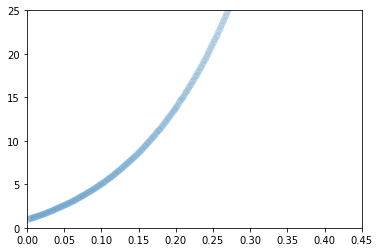

In [14]:
#for pure polymer
x_c = 0.0001
e_pc = 0.0
d_c = 1.0
d_p = 1.0
m_c = 1
m_p = 1
m = 16
ns = np.arange(0.0,0.50,0.001)
ps = (6*ns/(np.pi*d_p**3))/m

Zs = []
for p in ps:
    Zs.append(Z(p, x_c, e_pc, d_c, d_p, m_c, m_p, m))

#Zs = m*((1+ns+ns**2-ns**3)/(1-ns)**3 - ((m-1)/m)*(1+ns-(ns**2)/2)/((1-ns)*(1-ns/2)))

plt.xlim(0,0.45)
plt.ylim(0,25)

#plt.scatter(ns, Zcps)
plt.scatter(ns, Zs, alpha=0.09)

###   Stabilility and percolation calculation
Here we calculate the stability limits of the system via a standard spinodal calculation. For the helmholts free energy we only need to look at any determnant that contains n-1 degrees of freedom where n counts all the extensive variables.

---

In [18]:
def DA(p_c, p_p, e_pc,              #state variables
       d_c, d_p, m_c, m_p, m, #system parameters
       min_step                  #minimum step to use for hessian calculation
      ):
    
    #generate steps for calculating hessian
    hess_steps = nd.MinStepGenerator(base_step=min_step, step_ratio=2.0, num_steps=4)
    
    #calculate the hessian (stability matrix)
    calculate_hessian = lambda x: A(x[0], x[1], e_pc, d_c, d_p, m_c, m_p, m)
    stability_matrix = nd.Hessian(calculate_hessian, step=hess_steps)([p_c, p_p])
    
    #build the 3x3 (or 2x2) stability matrix as a numpy array and calculate the determinant 
    #logdet is used to avoid issues with a small determinant (such as when an instability is reached)
    (sign, logdet) = np.linalg.slogdet(stability_matrix)
    stability_determinant = sign*np.exp(logdet)    
        
    #return the stability determinant
    return stability_determinant

In [19]:
import scipy as sp

#performs grid search and labels each point as stable or unstable
def CalculateBoundary(p_c_vals, gamma, e_pc_vals,
                      d_c, d_p, m_c, m_p, m,
                      min_step, boundary_type,
                     ):


    #lists for storing the results
    boundary = [[],[],[],[]]

    #quantities to iterate over
    #p_c_vals_rev = list(reversed(p_c_vals))
    quants = {'p_c': p_c_vals,
              'e_pc': e_pc_vals}

    #iteration permutations
    iters = [('p_c', 'e_pc'), 
             ('e_pc', 'p_c')]
    #iters = [('e_pc', 'p_c')]

    #perform the loops in both directions
    for iter_1, iter_2 in iters:
        
        print "Performing ({}, {}) iteration...".format(iter_1, iter_2)

        for quant_1 in quants[iter_1]:

            #stacks to find crossover points iterating over quant_2
            value_queue = []
            quant_2_queue = []
            q0 = None

            for quant_2 in quants[iter_2]:

                #extract the values
                p_c = (iter_1 == 'p_c')*quant_1 + (iter_2 == 'p_c')*quant_2
                p_p = p_c*gamma
                e_pc = (iter_1 == 'e_pc')*quant_1 + (iter_2 == 'e_pc')*quant_2

                #perform the appropriate calculation
                if boundary_type == 'spinodal':
                    value = DA(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m, min_step)
                elif boundary_type == 'percolation':
                    value = Perc(p_c, p_p, e_pc, d_c, d_p, m_c, m_p, m)
                elif boundary_type == 'binodal':
                    value, q0 = PS(p_c+p_p, p_c/p_p, e_pc, d_c, d_p, m_c, m_p, m, q0, threshold=1.0e-6)

                #manage the queue
                if len(value_queue) == 4:
                    value_queue.pop(0); quant_2_queue.pop(0)
                value_queue.append(value); quant_2_queue.append(quant_2)

                #count the number of unstable points encountered
                ####num_neg = num_neg + (value < 0.0)

                #if we have two positive and negative points interpolate to find the crossover and break
                ####if num_neg == 2:
                if len(value_queue) == 4:
                    value_queue_sgn = np.sign(value_queue)
                    if np.all(value_queue_sgn[0:2] + value_queue_sgn[2:] == 0):

                        #fit an akima spline
                        fit = sp.interpolate.Akima1DInterpolator(quant_2_queue, value_queue)
                        roots = fit.roots()

                        #select which one to use and append
                        num_roots = len(roots)
                        p_c_ = (iter_1 == 'p_c')*p_c + (iter_2 == 'p_c')*( (num_roots == 1)*roots[0] - (num_roots != 1) )
                        e_pc_ = (iter_1 == 'e_pc')*e_pc + (iter_2 == 'e_pc')*( (num_roots == 1)*roots[0] - (num_roots != 1) )
                        boundary[0].append( p_c_ )
                        boundary[1].append( p_p )
                        boundary[2].append( e_pc_ )
                        boundary[3].append( ((np.pi/6.0)*d_c**3)*p_c_ )
                        #break

    return boundary

Find the spinodal boundary

In [20]:
def FindSpinodal(gamma, d_c, d_p, m_c, m_p, m,
                 n_c_min, n_c_max, e_pc_min, e_pc_max,
                 num_pts_p_c, num_pts_e_pc, num_pts_p_c_final, num_pts_e_pc_final,
                 min_step, expansion
                ):
    
    #auxillary
    p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
    p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

    #####################################################################################

    #set the ranges
    p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
    e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

    #spinodal
    print "Performing initial spinodal pass with {}x{} grid...".format(num_pts_p_c, num_pts_e_pc)
    spinodal_init = CalculateBoundary(p_c_vals, gamma, e_pc_vals, 
                                      d_c, d_p, m_c, m_p, m, 
                                      min_step, 'spinodal')

    #####################################################################################

    #get the new sampling details
    pc_range_final = max(spinodal_init[0]) - p_c_min
    e_pc_range_final = e_pc_max - min(spinodal_init[2])
    p_c_max_final = p_c_min + pc_range_final*(1.0 + expansion)
    e_pc_min_final = e_pc_max - e_pc_range_final*(1.0 + expansion)

    #set the ranges
    p_c_vals_final = np.linspace(p_c_min, p_c_max_final, num=num_pts_p_c_final)
    e_pc_vals_final = np.linspace(e_pc_min_final, e_pc_max, num=num_pts_e_pc_final)

    #spinodal
    print "Performing final spinodal pass with localized {}x{} grid...".format(num_pts_p_c_final, num_pts_e_pc_final)
    spinodal = CalculateBoundary(p_c_vals_final, gamma, e_pc_vals_final, 
                                 d_c, d_p, m_c, m_p, m, 
                                 min_step, 'spinodal')
    
    return spinodal

In [21]:
def FindPercolation(gamma, d_c, d_p, m_c, m_p, m,
                    n_c_min, n_c_max, e_pc_min, e_pc_max,
                    num_pts_p_c, num_pts_e_pc
                    ):
    
    #auxillary
    p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
    p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

    #####################################################################################

    #set the ranges
    p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
    e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

    #percolation
    print "Performing percolation pass with {}x{} grid...".format(num_pts_p_c, num_pts_e_pc)
    percolation = CalculateBoundary(p_c_vals, gamma, e_pc_vals, 
                                    d_c, d_p, m_c, m_p, m, 
                                    min_step, 'percolation')
    
    return percolation

In [114]:
#phase_data = {}

In [115]:
#system variables
#gamma = 3.0
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
#m = 8

In [117]:
#for paper
ms = [2, 4, 8, 16]
gammas = [1.5]

In [127]:
#for paper
ms = [8]
gammas = [0.9, 1.1, 1.5, 2.5, 3.0]

In [134]:
#for paper
ms = [8]
gammas = [1.1]

In [64]:
#ms = [8]
#gammas = [1.1, 1.5, 2.0, 2.5, 3.0]

In [98]:
#ms = [8]
#gammas = [0.9, 1.0]

In [112]:
#ms = [8]
#gammas = [0.7]

In [135]:
#search range and search parameters
n_c_min = 0.0001
n_c_max = 0.25
e_pc_min = 10.0
e_pc_max = 20.0
num_pts_p_c = 30 #120
num_pts_e_pc = 30 #120
num_pts_p_c_final = 60
num_pts_e_pc_final = 60
min_step= 0.0000001 #0.00001
expansion = 0.50

In [136]:
for m in ms:
    for gamma in gammas:
        print "Working on m = {}, gamma = {}".format(m, gamma)
        
        spinodal = FindSpinodal(gamma, d_c, d_p, m_c, m_p, m,
                                n_c_min, n_c_max, e_pc_min, e_pc_max,
                                num_pts_p_c, num_pts_e_pc, num_pts_p_c_final, num_pts_e_pc_final,
                                min_step, expansion
                                )

        phase_data[(m, gamma)] = {'spinodal': [spinodal[3], spinodal[2]]}

Working on m = 8, gamma = 1.1
Performing initial spinodal pass with 30x30 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...
Performing final spinodal pass with localized 60x60 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...


In [277]:
#import dill as pickle
#with open('./data/spinodal_examples_temp.pkl', 'wb') as file:
#    pickle.dump(phase_data, file)

In [8]:
#import dill as pickle
#with open('./data/spinodal_examples_temp.pkl', 'rb') as file:
#    phase_data = pickle.load(file)

In [137]:
#search range and search parameters
n_c_min = 0.0001
n_c_max = 0.3
e_pc_min = 0.0
e_pc_max = 20.0
num_pts_p_c = 400
num_pts_e_pc = 100

In [138]:
for m in ms: #[1, 2, 4, 8, 16]:
    for gamma in gammas: #[1, 3, 9]:
        print "Working on m = {}, gamma = {}".format(m, gamma)
        
        percolation = FindPercolation(gamma, d_c, d_p, m_c, m_p, m,
                              n_c_min, n_c_max, e_pc_min, e_pc_max,
                              num_pts_p_c, num_pts_e_pc
                              )

        phase_data[(m, gamma)]['percolation'] =  [percolation[3], percolation[2]]

Working on m = 8, gamma = 1.1
Performing percolation pass with 400x100 grid...
Performing (p_c, e_pc) iteration...
Performing (e_pc, p_c) iteration...


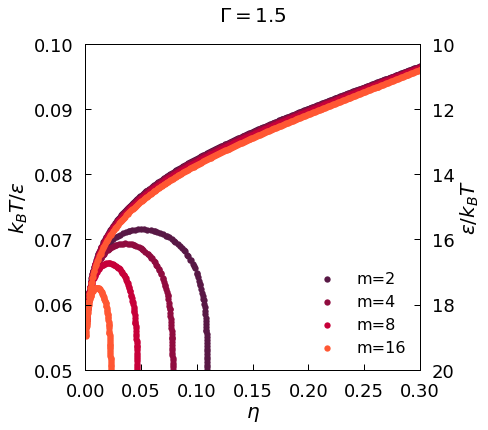

In [132]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
gamma = 1.5
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']))
#colors = list(reversed(['red', 'orange', 'green', 'blue', 'purple']))
counter = 0
for m in [2,4,8,16]:
    
    #spinodal pts
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    eta_spinodal, e_pc_spinodal = np.array(eta_spinodal), np.array(e_pc_spinodal)
    eta_spinodal_total = eta_spinodal + m*(d_p**3/d_c**3)*eta_spinodal*gamma
    
    #percolation pts
    eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    eta_percolation, e_pc_percolation = np.array(eta_percolation), np.array(e_pc_percolation)
    eta_percolation_total = eta_percolation + m*(d_p**3/d_c**3)*eta_percolation*gamma
    
    #plot the pts
    plt.scatter(eta_spinodal_total, 1/e_pc_spinodal, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0, label="m={}".format(m))
    plt.scatter(eta_percolation_total, 1/e_pc_percolation, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0)
    counter += 1

#add a legend
plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.000, 0.30])
e_inv_range = np.array([0.05, 0.10])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
plt.twinx()
plt.ylim(e_range)

###secondary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

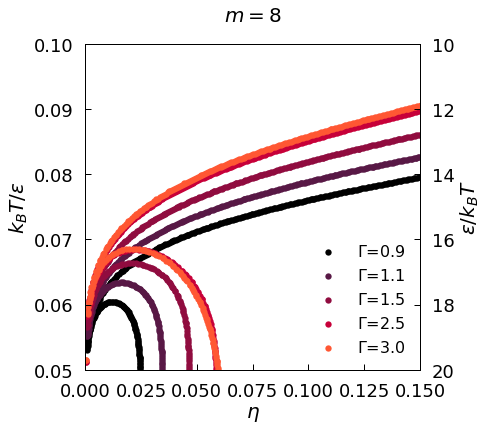

In [140]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
m = 8
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845', 'black']))
#colors = list(reversed(['red', 'orange', 'green', 'blue', 'purple']))
counter = 0
for gamma in [0.9, 1.1, 1.5, 2.5, 3.0]:
    
    #spinodal pts
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    eta_spinodal, e_pc_spinodal = np.array(eta_spinodal), np.array(e_pc_spinodal)
    eta_spinodal_total = eta_spinodal + m*(d_p**3/d_c**3)*eta_spinodal*gamma
    
    #percolation pts
    eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    eta_percolation, e_pc_percolation = np.array(eta_percolation), np.array(e_pc_percolation)
    eta_percolation_total = eta_percolation + m*(d_p**3/d_c**3)*eta_percolation*gamma
    
    #plot the pts
    plt.scatter(eta_spinodal_total, 1/e_pc_spinodal, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0, label="$\Gamma$={}".format(gamma))
    plt.scatter(eta_percolation_total, 1/e_pc_percolation, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0)
    counter += 1

#add a legend
plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.000, 0.15])
e_inv_range = np.array([0.05, 0.10])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$m = {}$".format(m), y=1.05, fontdict = title_font)

#make another axis
plt.twinx()
plt.ylim(e_range)

###secondary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(m), bbox_inches='tight', dpi=100)

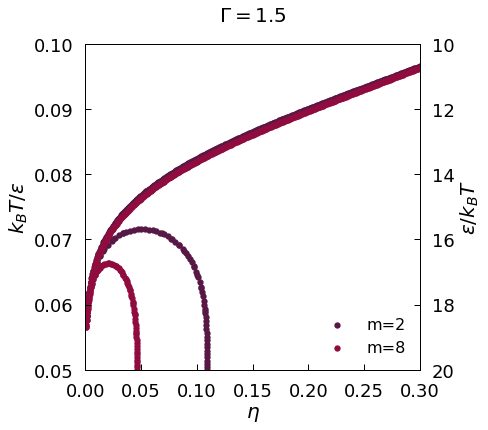

In [35]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
gamma = 1.5
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']))
#colors = list(reversed(['red', 'orange', 'green', 'blue', 'purple']))
counter = 0
for m in [2,8]:
    
    #spinodal pts
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    eta_spinodal, e_pc_spinodal = np.array(eta_spinodal), np.array(e_pc_spinodal)
    eta_spinodal_total = eta_spinodal + m*(d_p**3/d_c**3)*eta_spinodal*gamma
    
    #percolation pts
    eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    eta_percolation, e_pc_percolation = np.array(eta_percolation), np.array(e_pc_percolation)
    eta_percolation_total = eta_percolation + m*(d_p**3/d_c**3)*eta_percolation*gamma
    
    #plot the pts
    plt.scatter(eta_spinodal_total, 1/e_pc_spinodal, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0, label="m={}".format(m))
    plt.scatter(eta_percolation_total, 1/e_pc_percolation, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0)
    counter += 1

#add a legend
plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.000, 0.30])
e_inv_range = np.array([0.05, 0.10])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
plt.twinx()
plt.ylim(e_range)

###secondary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)

#plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

## Phase coexistence

In [ ]:
def A2PUnconstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                       O_1, p_1, x_c_1, 
                       O_2, p_2, x_c_2):
    
    #bulk molecular densities
    p_c = p*x_c
    p_p = p*(1.0 - x_c)
    
    #phase 1 molecular densities
    p_c_1 = p_1*x_c_1
    p_p_1 = p_1*(1.0 - x_c_1)
    
    #phase 2 molecular densities
    p_c_2 = p_2*x_c_2
    p_p_2 = p_2*(1.0 - x_c_2)
    
    #free energies of the two phases (each per N and not V)
    a_1_pN = A(p_c_1, p_p_1, e_pc, d_c, d_p, m_c, m_p, m) / p_1
    a_2_pN = A(p_c_2, p_p_2, e_pc, d_c, d_p, m_c, m_p, m) / p_2
    
    return O_1*(p_1/p)*a_1_pN + O_2*(p_2/p)*a_2_pN

In [ ]:
def A2PConstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                     p_1, x_c_1, p_2):
    
    #implement constraints
    O_1 = (-p + p_2)/(p_2 - p_1)
    O_2 = (-p + p_1)/(p_1 - p_2)
    x_c_2 = (-(p*p_1*x_c) + p*p_2*x_c + p*p_1*x_c_1 - p_1*p_2*x_c_1)/((p - p_1)*p_2)
    
    #calculate the free energy with the constraints using the unconstrained form
    a2p_pN = A2PUnconstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                                O_1, p_1, x_c_1, 
                                O_2, p_2, x_c_2)
    
    #puts a penalty on unphysical solutions
    a_pen = 1e10*(O_1 < 0.0 or O_1 > 1.0 or 
                  O_2 < 0.0 or O_2 > 1.0 or 
                  x_c_1 < 0.0 or x_c_1 > 1.0 or 
                  x_c_2 < 0.0 or x_c_2 > 1.0
                 )
    
    return a2p_pN + a_pen

In [ ]:
def FindPhases(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0=None):
    
    #optimizable function
    if q0 is None:
        q0 = np.array([p-0.00001, x_c, p+0.000001])
    func = lambda q: A2PConstrainedPN(p, x_c, e_pc, d_c, d_p, m_c, m_p, m,
                                      q[0], q[1], q[2])
    
    #minimize using the simplex method
    res = sp.optimize.minimize(func, q0, method='Nelder-Mead',
                               options={'xtol': 1e-12, 'disp': False, 'maxiter':500})
                               #options={'xtol': 1e-12, 'disp': False, 'maxiter':1000})
    
    #solver found variables
    p_1 = res.x[0]
    x_c_1 = res.x[1]
    p_2 = res.x[2]
    
    #related variables
    O_1 = (-p + p_2)/(p_2 - p_1)
    O_2 = (-p + p_1)/(p_1 - p_2)
    x_c_2 = (-(p*p_1*x_c) + p*p_2*x_c + p*p_1*x_c_1 - p_1*p_2*x_c_1)/((p - p_1)*p_2)
    
    return ((p_1, x_c_1, O_1), (p_2, x_c_2, O_2))

In [ ]:
def PS(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0, threshold=1e-5):
    
    #two phase results
    ((p_1, x_c_1, O_1), (p_2, x_c_2, O_2)) = FindPhases(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0)
    
    #needed parameters for computing free energy of each phase per V
    p_c_1 = p_1*x_c_1
    p_p_1 = p_1*(1.0 - x_c_1)
    p_c_2 = p_2*x_c_2
    p_p_2 = p_2*(1.0 - x_c_2)
    
    sensitivity = O_1*O_2*np.sqrt(np.power((p_1 - p_2)/np.mean([p_1, p_2]), 2) 
                  + np.power((x_c_1 - x_c_2)/np.mean([x_c_1, x_c_2]), 2)) - threshold
    
    return sensitivity, (p_1, x_c_1, p_2)

In [22]:
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
m = 1

############
n_c = 0.10
gamma = 3.0
e_pc = 14.0

############
p_c = 6.0*n_c/(np.pi*d_c**3)
p_p = p_c*gamma
p = p_c + p_p
x_c = p_c / p


((p_1, x_c_1, O_1), (p_2, x_c_2, O_2)) = FindPhases(p, x_c, e_pc, d_c, d_p, m_c, m_p, m)
print (p_1, x_c_1, O_1)
print (p_2, x_c_2, O_2)

#free energies of the two phases (each per N and not V)
p_c_1 = p_1*x_c_1
p_p_1 = p_1*(1.0 - x_c_1)
p_c_2 = p_2*x_c_2
p_p_2 = p_2*(1.0 - x_c_2)
print O_1*A(p_c_1, p_p_1, e_pc, d_c, d_p, m_c, m_p, m)
print O_2*A(p_c_2, p_p_2, e_pc, d_c, d_p, m_c, m_p, m)

PS(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0=None, threshold=0.00001)

(0.00042079363491657595, 0.0774325833591833, 0.5766341170670868)
(0.013862491252090811, 0.2571346250016762, 0.42336588293291333)
-0.0014653917980729668
-0.037065622908031615


(0.03802148734208654,
 (0.00042079363491657595, 0.0774325833591833, 0.013862491252090811))

In [24]:
#system variables
gamma = 3.0
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
m = 1

min_step= 0.0000001 #0.00001

In [25]:
#search range and search parameters
n_c_min = 0.001
n_c_max = 0.15
e_pc_min = 10.0
e_pc_max = 19.5
num_pts_p_c = 20
num_pts_e_pc = 100

#auxillary
p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

#set the ranges
p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

In [39]:
n_c = 0.19
gamma = 3.0

e_pc_min = 10.0
e_pc_max = 20.0
num_pts_e_pc = 300

p_c = 6.0*n_c/(np.pi*d_c**3)
p_p = p_c*gamma
p = p_c + p_p
x_c = p_c / p
e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

q0 = None
senss = []
counter = 0
for e_pc in reversed(e_pc_vals):
    print counter
    sens, q0 = PS(p, x_c, e_pc, d_c, d_p, m_c, m_p, m, q0, threshold=1.0e-6)
    senss.append(sens)
    counter += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Bisection for PC

In [34]:
import scipy as sp

def CalculatePCBoundary(p_c_vals, e_pc_min, e_pc_max, num_pts_epc,
                        gamma,
                        d_c, d_p, m_c, m_p, m,
                        threshold=1e-5, threshold_op=1e-5
                        ):


    #lists for storing the results
    boundary = [[],[],[],[]]
    
    #store for loops
    e_pc_min_init = e_pc_min
    e_pc_max_init = e_pc_max
    q0_1_init = None

    #use bisection to find the phase coexistence boundary
    for p_c in p_c_vals:
        
        print 'Current n_c = {}'.format((np.pi/6.0)*p_c*d_c**3)
        
        #initialize search range
        e_pc_min = e_pc_min_init
        e_pc_max = e_pc_max_init
        
        #get relevant variables
        p_p = p_c*gamma
        p = p_c + p_p
        x_c = p_c/p

        #initial point
        e_pc_1 = e_pc_max
        op_1, q0_1 = PS(p, x_c, e_pc_1, d_c, d_p, m_c, m_p, m, q0_1_init, threshold_op)
        q0_1_init = q0_1
        
        #bisection of the attraction strength
        while (e_pc_max - e_pc_min) > threshold*np.mean([e_pc_max, e_pc_min]):
            
            #manually start with the first two points
            del_e_pc = (e_pc_max - e_pc_min)/num_pts_epc
            e_pc_2 = e_pc_1 - del_e_pc
            op_2, q0_2 = PS(p, x_c, e_pc_2, d_c, d_p, m_c, m_p, m, q0_1, threshold_op)            
            print "e_pc_min = {}, e_pc_max = {}".format(e_pc_min, e_pc_max)
            
            #finding the new min and max attraction 
            while op_2 > 0.0:
                
                #move newer to older
                e_pc_1 = e_pc_2
                op_1 = op_2
                q0_1 = q0_2
                
                #generate new lookahead
                e_pc_2 = e_pc_1 - del_e_pc
                op_2, q0_2 = PS(p, x_c, e_pc_2, d_c, d_p, m_c, m_p, m, q0_1, threshold_op)
            
            #adjust the min, max and spacing values
            e_pc_min = e_pc_2
            e_pc_max = e_pc_1
        
        #store the boundary
        boundary[0].append( p_c )
        boundary[1].append( p_p )
        boundary[2].append( np.mean([e_pc_min, e_pc_max]) )
        boundary[3].append( ((np.pi/6.0)*d_c**3)*p_c )

    return boundary

In [125]:
m = 4
gamma = 3.0

n_c_min = 0.001
n_c_max = 0.35
e_pc_min = 10.0
e_pc_max = 19.99
num_pts_epc = 20
num_pts_p_c = 200

#auxillary
p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

#set the ranges
p_c_vals = np.linspace(p_c_min, p_c_max, num=num_pts_p_c)
e_pc_vals = np.linspace(e_pc_min, e_pc_max, num=num_pts_e_pc)

In [ ]:
binodal = CalculatePCBoundary(p_c_vals, e_pc_min, e_pc_max, num_pts_epc,
                              gamma,
                              d_c, d_p, m_c, m_p, m,
                              threshold=1e-6, threshold_op=1e-6
                              )

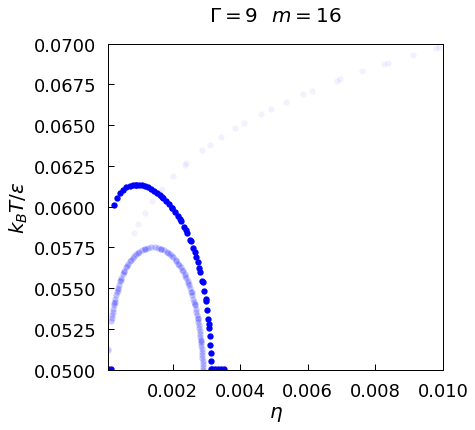

In [137]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
plt.scatter(phase_data[(m,gamma)]['spinodal'][0], 1/np.array(phase_data[(m,gamma)]['spinodal'][1]), 
            c='blue', marker="o", s=40, alpha=0.2, linewidths=0.0, label="m={}".format(m))

plt.scatter(phase_data[(m,gamma)]['percolation'][0], 1/np.array(phase_data[(m,gamma)]['percolation'][1]), 
            c='blue', marker="o", s=40, alpha=0.05, linewidths=0.0, label="m={}".format(m))

plt.scatter(binodal[3], 1/np.array(binodal[2]), 
            c='blue', marker="o", s=40, alpha=1.0, linewidths=0.0, label="m={}".format(m))

#add a legend
#plt.legend(loc='lower right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.0001, 0.01])
e_inv_range = np.array([0.05, 0.07])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
plt.ylim(tuple(e_inv_range))
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$k_{B}T/\epsilon$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$  $m = {}$".format(gamma, m), y=1.05, fontdict = title_font)

#make another axis
#plt.twinx()
#plt.ylim(e_range)

###secondary axis settings
#plt.rcParams["figure.figsize"] = [6,6]
#plt.rc('axes',edgecolor='black',linewidth=1)
#plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
#plt.rcParams['xtick.direction'] = 'in'
#plt.rcParams['ytick.direction'] = 'in'

#plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
#plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_with_ps.png'.format(gamma), bbox_inches='tight', dpi=100)

In [94]:
1/0.07

14.285714285714285

In [35]:
import scipy as sp

def CalculatePCBoundary(p_c_vals, e_pc_min, e_pc_max, num_pts_epc,
                        num_e_pc_vals, num_pts_p_c,
                        gamma,
                        d_c, d_p, m_c, m_p, m,
                        threshold=1e-5, threshold_op=1e-5
                        ):


    #lists for storing the results
    boundary = [[],[],[],[]]
    
    print "PERFORMING DOWNWARD SEARCH..."
    
    #store for loops
    e_pc_min_init = e_pc_min
    e_pc_max_init = e_pc_max
    q0_1_init = None

    #use bisection to find the phase coexistence boundary
    for p_c in p_c_vals:
        
        print 'Current n_c = {}'.format((np.pi/6.0)*p_c*d_c**3)
        
        #initialize search range
        e_pc_min = e_pc_min_init
        e_pc_max = e_pc_max_init
        
        #get relevant variables
        p_p = p_c*gamma
        p = p_c + p_p
        x_c = p_c/p

        #initial point
        e_pc_1 = e_pc_max
        op_1, q0_1 = PS(p, x_c, e_pc_1, d_c, d_p, m_c, m_p, m, q0_1_init, threshold_op)
        q0_1_init = q0_1
        
        #bisection of the attraction strength
        while (e_pc_max - e_pc_min) > threshold*np.mean([e_pc_max, e_pc_min]):
            
            #manually start with the first two points
            del_e_pc = (e_pc_max - e_pc_min)/num_pts_epc
            e_pc_2 = e_pc_1 - del_e_pc
            op_2, q0_2 = PS(p, x_c, e_pc_2, d_c, d_p, m_c, m_p, m, q0_1, threshold_op)            
            print "e_pc_min = {}, e_pc_max = {}".format(e_pc_min, e_pc_max)
            
            #finding the new min and max attraction 
            while op_2 > 0.0 and e_pc_2 > e_pc_min:
                
                #move newer to older
                e_pc_1 = e_pc_2
                op_1 = op_2
                q0_1 = q0_2
                
                #generate new lookahead
                e_pc_2 = e_pc_1 - del_e_pc
                op_2, q0_2 = PS(p, x_c, e_pc_2, d_c, d_p, m_c, m_p, m, q0_1, threshold_op)
            
            #adjust the min, max and spacing values
            e_pc_min = e_pc_2
            e_pc_max = e_pc_1
        
        #store the boundary
        boundary[0].append( p_c )
        boundary[1].append( p_p )
        boundary[2].append( np.mean([e_pc_min, e_pc_max]) )
        boundary[3].append( ((np.pi/6.0)*d_c**3)*p_c )
        
        #if nothing found on low end then always start fresh
        nothing_yet = np.all(np.abs(np.array(boundary[2][:]) - e_pc_max) < 1e-3)
        if nothing_yet:
            q0_1_init = None
        
        #do not waste time if we are calculating the same thing
        if len(boundary[2]) > 10:
            if not nothing_yet:
                if np.all(np.abs(np.array(boundary[2][-5:-1]) - e_pc_max) < 1e-3):
                    print "Terminating early in density."
                    break
        
    ################################################################################
    
    print "PERFORMING LEFTWARD / RIGHTWARD SEARCH..."
    
    #find the maximum e_pc and the corresponding density
    index_min_boundary = np.argmin(boundary[2])
    e_pc_min_boundary = boundary[2][index_min_boundary]
    p_c_cen = boundary[0][index_min_boundary]
    p_c_max = p_c_vals[-1]
    
    print "n_c_cen: {}".format(((np.pi/6.0)*d_c**3)*p_c_cen)
    print "n_c_max: {}".format(((np.pi/6.0)*d_c**3)*p_c_max)
    
    #generate a selection of points in the range of e_pc discovered
    e_pc_vals = np.linspace(e_pc_min_boundary, e_pc_max, num=num_e_pc_vals)
    
    #store for loops
    p_c_cen_init = p_c_cen
    p_c_max_init = p_c_max
    p_c_min_init = 0.0
    q0_1_init = None
    
    #loop over the desired attraction strengths
    for e_pc in list(reversed(e_pc_vals)):
        
        print 'Current e_pc = {}'.format(e_pc)
        
        #search in both directions
        for direction in ['right']: # ['left', 'right']:
            
            print 'Moving {}'.format(direction)
        
            #initialize search range
            p_c_min = (direction == 'left')*p_c_min_init + (direction == 'right')*p_c_cen_init
            p_c_max = (direction == 'left')*p_c_cen_init + (direction == 'right')*p_c_max_init

            #get relevant variables
            p_c_1 = (direction == 'left')*p_c_max + (direction == 'right')*p_c_min
            p_p_1 = p_c_1*gamma
            p_1 = p_c_1 + p_p_1
            x_c_1 = p_c_1/p_1

            #initial point
            op_1, q0_1 = PS(p_1, x_c_1, e_pc, d_c, d_p, m_c, m_p, m, q0_1_init, threshold_op)
            q0_1_init = q0_1

            #bisection of the attraction strength
            while (p_c_max - p_c_min) > threshold*np.mean([p_c_min, p_c_max]):

                #manually start with the first two points
                del_p_c = (p_c_max - p_c_min)/num_pts_p_c
                p_c_2 = p_c_1 - (direction == 'left')*del_p_c + (direction == 'right')*del_p_c
                p_p_2 = p_c_2*gamma
                p_2 = p_c_2 + p_p_2
                x_c_2 = p_c_2/p_2
                op_2, q0_2 = PS(p_2, x_c_2, e_pc, d_c, d_p, m_c, m_p, m, q0_1, threshold_op)            
                print "n_c_min = {}, n_c_max = {}".format((np.pi/6.0)*p_c_min*d_c**3, 
                                                          (np.pi/6.0)*p_c_max*d_c**3)

                #finding the new min and max attraction 
                while op_2 > 0.0:

                    #move newer to older
                    p_c_1 = p_c_2
                    op_1 = op_2
                    q0_1 = q0_2

                    #generate new lookahead
                    p_c_2 = p_c_1 - (direction == 'left')*del_p_c + (direction == 'right')*del_p_c
                    p_p_2 = p_c_2*gamma
                    p_2 = p_c_2 + p_p_2
                    x_c_2 = p_c_2/p_2
                    op_2, q0_2 = PS(p_2, x_c_2, e_pc, d_c, d_p, m_c, m_p, m, q0_1, threshold_op)

                #adjust the min, max and spacing values
                p_c_min = (direction == 'left')*p_c_2 + (direction == 'right')*p_c_1
                p_c_max = (direction == 'left')*p_c_1 + (direction == 'right')*p_c_2

            #store the boundary
            p_c_ = np.mean([p_c_min, p_c_max])
            p_p_ = p_c_*gamma
            boundary[0].append( p_c_ )
            boundary[1].append( p_p_ )
            boundary[2].append( e_pc )
            boundary[3].append( ((np.pi/6.0)*d_c**3)*p_c_ )

    return boundary

In [36]:
gamma = 3.0
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 
m = 4

#generate the eta points to iterate upwards from in attraction strength
n_c_min = 0.0001    #TUNE
n_c_max = 0.009    #TUNE
p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
p_c_max = 6.0*n_c_max/(np.pi*d_c**3)

#upwards search
num_p_c_vals = 100 #40 #TUNE
p_c_vals = np.linspace(p_c_min, p_c_max, num=num_p_c_vals)
e_pc_min = 11.0    #TUNE
e_pc_max = 19.99   #TUNE
num_pts_epc = 40   #TUNE

#leftwards and rightwards search
num_e_pc_vals = 60 #40 #TUNE
num_pts_p_c = 40   #TUNE

In [44]:
m = 16
gamma = 9

In [ ]:
binodal = CalculatePCBoundary(p_c_vals, e_pc_min, e_pc_max, num_pts_epc,
                              num_e_pc_vals, num_pts_p_c,
                              gamma,
                              d_c, d_p, m_c, m_p, m,
                              threshold=1e-4, threshold_op=1e-5
                              )

In [45]:
d_c = 5.0
d_p = 1.0
m_c = 6.0
m_p = 2.0 

In [46]:
ms = [2, 8] #[2, 4, 8, 16]
gammas = [1.5] #[9, 3, 1] #[1, 3, 9]

In [ ]:
for m in ms:
    for gamma in gammas:

        print "Working on m = {}, gamma = {}".format(m, gamma)
        
        #get spinodal data to inform ranges etc.
        n_c_spinodal = phase_data[(m, gamma)]['spinodal'][0]
        e_pc_spinodal = phase_data[(m, gamma)]['spinodal'][1]
        
        #set the range in colloid packing fraction
        n_c_min = 0.001
        n_c_max = 2*max(n_c_spinodal)
        ########d_n_c = 0.0002
        ########n_c_vals = np.arange(n_c_min, n_c_max, d_n_c)
        p_c_min = 6.0*n_c_min/(np.pi*d_c**3)
        p_c_max = 6.0*n_c_max/(np.pi*d_c**3)
        
        print "n_c_max = {}, n_c_min = {}".format(n_c_max, n_c_min)
        
        #upwards search
        num_p_c_vals = 60 #80
        p_c_vals = np.linspace(p_c_min, p_c_max, num=num_p_c_vals)
        ########p_c_vals = 6.0*n_c_vals/(np.pi*d_c**3)
        e_pc_max = 19.999 
        e_pc_min = max(10.0, e_pc_max - 1.3*(e_pc_max - min(e_pc_spinodal)))
        num_pts_epc = 20 #10
        
        print "e_pc_max = {}, e_pc_min = {}\n".format(e_pc_max, e_pc_min)

        #leftwards and rightwards search
        num_e_pc_vals = 50 #50
        num_pts_p_c = 20
        
        #find the binodal
        binodal = CalculatePCBoundary(p_c_vals, e_pc_min, e_pc_max, num_pts_epc,
                                      num_e_pc_vals, num_pts_p_c,
                                      gamma,
                                      d_c, d_p, m_c, m_p, m,
                                      threshold=1e-5, threshold_op=1e-5
                                      )

        phase_data[(m, gamma)]['binodal'] =  [binodal[3], binodal[2]]

Working on m = 2, gamma = 1.5
n_c_max = 0.213917403976, n_c_min = 0.001
e_pc_max = 19.999, e_pc_min = 12.1702883708

PERFORMING DOWNWARD SEARCH...
Current n_c = 0.001
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 15.3017730225, e_pc_max = 15.693208604
e_pc_min = 15.5757779295, e_pc_max = 15.5953497086
e_pc_min = 15.5806708743, e_pc_max = 15.5816494633
Current n_c = 0.00460876955891
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 14.5189018596, e_pc_max = 14.9103374411
e_pc_min = 14.6754760922, e_pc_max = 14.6950478712
e_pc_min = 14.6803690369, e_pc_max = 14.6813476259
Current n_c = 0.00821753911783
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 14.1274662781, e_pc_max = 14.5189018596
e_pc_min = 14.3818994061, e_pc_max = 14.4014711852
e_pc_min = 14.3867923509, e_pc_max = 14.3877709398
Current n_c = 0.0118263086767
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 14.1274662781, e_pc_max = 14.5189018596
e_pc_min = 14.2057533944, e_pc_max = 14.2253251735
e_pc_

e_pc_min = 19.998021411, e_pc_max = 19.999
Current n_c = 0.130915704121
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 19.6075644185, e_pc_max = 19.999
e_pc_min = 19.9794282209, e_pc_max = 19.999
e_pc_min = 19.998021411, e_pc_max = 19.999
Current n_c = 0.13452447368
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 19.6075644185, e_pc_max = 19.999
e_pc_min = 19.9794282209, e_pc_max = 19.999
e_pc_min = 19.998021411, e_pc_max = 19.999
Current n_c = 0.138133243239
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 19.6075644185, e_pc_max = 19.999
e_pc_min = 19.9794282209, e_pc_max = 19.999
e_pc_min = 19.998021411, e_pc_max = 19.999
Current n_c = 0.141742012798
e_pc_min = 12.1702883708, e_pc_max = 19.999
e_pc_min = 19.6075644185, e_pc_max = 19.999
e_pc_min = 19.9794282209, e_pc_max = 19.999
e_pc_min = 19.998021411, e_pc_max = 19.999
Terminating early in density.
PERFORMING LEFTWARD / RIGHTWARD SEARCH...
n_c_cen: 0.0370876955891
n_c_max: 0.213917403976
Current e_pc = 19.999

n_c_min = 0.116661064363, n_c_max = 0.125502549782
n_c_min = 0.121081807073, n_c_max = 0.121523881344
n_c_min = 0.121391259062, n_c_max = 0.121413362776
Current e_pc = 16.2792186248
Moving right
n_c_min = 0.0370876955891, n_c_max = 0.213917403976
n_c_min = 0.116661064363, n_c_max = 0.125502549782
n_c_min = 0.120639732802, n_c_max = 0.121081807073
n_c_min = 0.120661836515, n_c_max = 0.120683940229
Current e_pc = 16.1552259123
Moving right
n_c_min = 0.0370876955891, n_c_max = 0.213917403976
n_c_min = 0.116661064363, n_c_max = 0.125502549782
n_c_min = 0.11975558426, n_c_max = 0.120197658531
n_c_min = 0.119866102828, n_c_max = 0.119888206541
Current e_pc = 16.0312331998
Moving right
n_c_min = 0.0370876955891, n_c_max = 0.213917403976
n_c_min = 0.116661064363, n_c_max = 0.125502549782
n_c_min = 0.118871435718, n_c_max = 0.119313509989
n_c_min = 0.118959850572, n_c_max = 0.118981954286
Current e_pc = 15.9072404873
Moving right
n_c_min = 0.0370876955891, n_c_max = 0.213917403976
n_c_min = 0.1

e_pc_min = 13.6002815618, e_pc_max = 19.999
e_pc_min = 14.8800252494, e_pc_max = 15.1999611713
e_pc_min = 15.0559900065, e_pc_max = 15.0719868026
e_pc_min = 15.0559900065, e_pc_max = 15.0567898463
Current n_c = 0.0166637351908
e_pc_min = 13.6002815618, e_pc_max = 19.999
e_pc_min = 14.8800252494, e_pc_max = 15.1999611713
e_pc_min = 15.0559900065, e_pc_max = 15.0719868026
e_pc_min = 15.0559900065, e_pc_max = 15.0567898463
Current n_c = 0.0180877111172
e_pc_min = 13.6002815618, e_pc_max = 19.999
e_pc_min = 14.8800252494, e_pc_max = 15.1999611713
e_pc_min = 15.0559900065, e_pc_max = 15.0719868026
e_pc_min = 15.0615888851, e_pc_max = 15.0623887249
Current n_c = 0.0195116870437
e_pc_min = 13.6002815618, e_pc_max = 19.999
e_pc_min = 14.8800252494, e_pc_max = 15.1999611713
e_pc_min = 15.0719868026, e_pc_max = 15.0879835987
e_pc_min = 15.0719868026, e_pc_max = 15.0727866424
Current n_c = 0.0209356629701
e_pc_min = 13.6002815618, e_pc_max = 19.999
e_pc_min = 14.8800252494, e_pc_max = 15.19996117

n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0536159104818, n_c_max = 0.0571046515016
n_c_min = 0.0565813403486, n_c_max = 0.0567557773996
n_c_min = 0.0566947244318, n_c_max = 0.0567034462843
Current e_pc = 19.7972453062
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0536159104818, n_c_max = 0.0571046515016
n_c_min = 0.0565813403486, n_c_max = 0.0567557773996
n_c_min = 0.0566685588741, n_c_max = 0.0566772807267
Current e_pc = 19.6963679593
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0536159104818, n_c_max = 0.0571046515016
n_c_min = 0.0565813403486, n_c_max = 0.0567557773996
n_c_min = 0.0566336714639, n_c_max = 0.0566423933165
Current e_pc = 19.5954906124
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0536159104818, n_c_max = 0.0571046515016
n_c_min = 0.0565813403486, n_c_max = 0.0567557773996
n_c_min = 0.0565900622012, n_c_max = 0.0565987840537
Current e_pc = 19.49461326

n_c_min = 0.050476043564, n_c_max = 0.050650480615
n_c_min = 0.0505894276472, n_c_max = 0.0505981494997
Current e_pc = 16.5691702058
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0466384284423, n_c_max = 0.0501271694621
n_c_min = 0.0499527324111, n_c_max = 0.0501271694621
n_c_min = 0.0499527324111, n_c_max = 0.0499614542636
Current e_pc = 16.4682928589
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0466384284423, n_c_max = 0.0501271694621
n_c_min = 0.0490805471561, n_c_max = 0.0492549842071
n_c_min = 0.0492462623546, n_c_max = 0.0492549842071
Current e_pc = 16.367415512
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0466384284423, n_c_max = 0.0501271694621
n_c_min = 0.0483827989522, n_c_max = 0.0485572360032
n_c_min = 0.0484612956251, n_c_max = 0.0484700174777
Current e_pc = 16.2665381651
Moving right
n_c_min = 0.0152397592644, n_c_max = 0.0850145796598
n_c_min = 0.0466384284423, n_c_max = 0.0

In [ ]:
phase_data

In [ ]:
print 'hi'

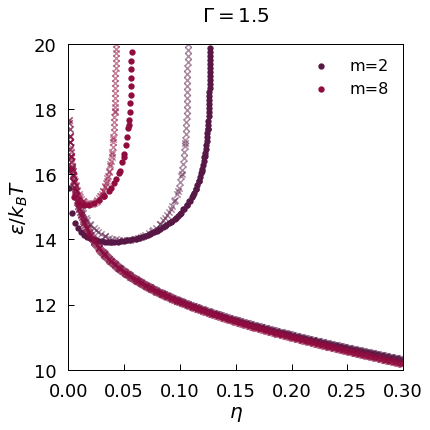

In [64]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
gamma = 1.5
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']))
eta_cutoff= 0.0006
e_pc_cutoff = 19.98
counter = 0
for m in [2,8]:
    
    #spinodal pts
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    eta_spinodal, e_pc_spinodal = np.array(eta_spinodal), np.array(e_pc_spinodal)
    
    #percolation pts
    eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    eta_percolation, e_pc_percolation = np.array(eta_percolation), np.array(e_pc_percolation)
    
    #binodal pts
    eta_binodal, e_pc_binodal = phase_data[(m, gamma)]['binodal']
    eta_binodal, e_pc_binodal = np.array(eta_binodal), np.array(e_pc_binodal)
    eta_mask = eta_binodal > eta_cutoff ####
    eta_binodal = eta_binodal[eta_mask]
    e_pc_binodal = e_pc_binodal[eta_mask]
    e_pc_mask = e_pc_binodal < e_pc_cutoff ####
    eta_binodal = eta_binodal[e_pc_mask]
    e_pc_binodal = e_pc_binodal[e_pc_mask]
    
    #plot the pts
    plt.scatter(eta_spinodal, e_pc_spinodal, 
                c=colors[counter], marker="x", s=40, alpha=0.5, linewidths=0.0)
    plt.scatter(eta_percolation, e_pc_percolation, 
                c=colors[counter], marker="x", s=40, alpha=0.5, linewidths=0.0)
    plt.scatter(eta_binodal, e_pc_binodal, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0,label="m={}".format(m))
    counter += 1

#add a legend
plt.legend(loc='upper right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.0001, 0.3])
e_inv_range = np.array([0.05, 1])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
#plt.ylim(tuple(e_inv_range))
#plt.ylim(list(reversed(e_range)))
plt.ylim(10,20)
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$\epsilon/k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
#plt.twinx()
#plt.ylim(e_range)

###secondary axis settings
#plt.rcParams["figure.figsize"] = [6,6]
#plt.rc('axes',edgecolor='black',linewidth=1)
#plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
#plt.rcParams['xtick.direction'] = 'in'
#plt.rcParams['ytick.direction'] = 'in'

#plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
#plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

In [183]:
len(np.arange(0.0001, 0.05, 0.0002))

250

In [194]:
print (m, gamma)

(16, 1)


In [205]:
1/1

1.0

In [276]:
len(np.arange(0.42,0.66,0.005))

49

In [61]:
e_pc_min

13.600599169988937

In [43]:
phase_data.keys()

[(2, 1.5), (8, 1.5)]

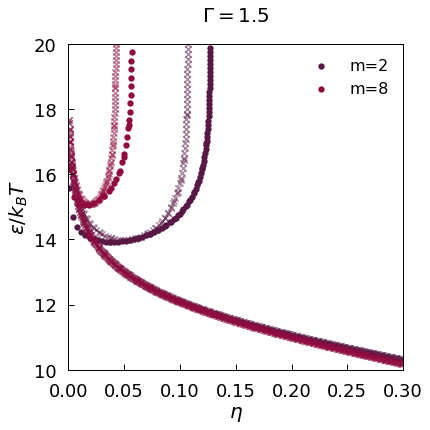

In [48]:
fig=plt.figure()

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}

#plot the data
gamma = 1.5
colors = list(reversed(['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845']))
eta_cutoff= 0.0006
e_pc_cutoff = 19.98
counter = 0
for m in [2,8]:
    
    #spinodal pts
    eta_spinodal, e_pc_spinodal = phase_data[(m, gamma)]['spinodal']
    eta_spinodal, e_pc_spinodal = np.array(eta_spinodal), np.array(e_pc_spinodal)
    
    #percolation pts
    eta_percolation, e_pc_percolation = phase_data[(m, gamma)]['percolation']
    eta_percolation, e_pc_percolation = np.array(eta_percolation), np.array(e_pc_percolation)
    
    #binodal pts
    eta_binodal, e_pc_binodal = phase_data[(m, gamma)]['binodal']
    eta_binodal, e_pc_binodal = np.array(eta_binodal), np.array(e_pc_binodal)
    eta_mask = eta_binodal > eta_cutoff ####
    eta_binodal = eta_binodal[eta_mask]
    e_pc_binodal = e_pc_binodal[eta_mask]
    e_pc_mask = e_pc_binodal < e_pc_cutoff ####
    eta_binodal = eta_binodal[e_pc_mask]
    e_pc_binodal = e_pc_binodal[e_pc_mask]
    
    #plot the pts
    plt.scatter(eta_spinodal, e_pc_spinodal, 
                c=colors[counter], marker="x", s=40, alpha=0.5, linewidths=0.0)
    plt.scatter(eta_percolation, e_pc_percolation, 
                c=colors[counter], marker="x", s=40, alpha=0.5, linewidths=0.0)
    plt.scatter(eta_binodal, e_pc_binodal, 
                c=colors[counter], marker="o", s=40, alpha=1.0, linewidths=0.0,label="m={}".format(m))
    counter += 1

#add a legend
plt.legend(loc='upper right', fontsize=16, frameon=False)

#set the ranges
n_c_range = np.array([0.0001, 0.3])
e_inv_range = np.array([0.05, 1])
e_range = 1.0 / e_inv_range
plt.xlim(tuple(n_c_range))
#plt.ylim(tuple(e_inv_range))
#plt.ylim(list(reversed(e_range)))
plt.ylim(10,20)
#plt.xscale('log')

###primary axis settings
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.xlabel('$\eta$', fontsize=20, fontdict = axis_label_font)
plt.ylabel('$\epsilon/k_{B}T$', fontsize=20, fontdict = axis_label_font)
plt.tick_params(axis='both', labelsize=18, pad=12)
plt.title("$\Gamma = {}$".format(gamma), y=1.05, fontdict = title_font)

#make another axis
#plt.twinx()
#plt.ylim(e_range)

###secondary axis settings
#plt.rcParams["figure.figsize"] = [6,6]
#plt.rc('axes',edgecolor='black',linewidth=1)
#plt.tick_params(which='both', axis='both', color='black', length=6, width=1.0)
#plt.rcParams['xtick.direction'] = 'in'
#plt.rcParams['ytick.direction'] = 'in'

#plt.ylabel('$\epsilon / k_{B}T$', fontsize=20, fontdict = axis_label_font)
#plt.tick_params(axis='both', labelsize=18, pad=12)

plt.savefig('./data/colloid_polymer_gamma={}.png'.format(gamma), bbox_inches='tight', dpi=100)

In [143]:
filebase = './data/'

for m, gamma in phase_data:
    
    for type in ['spinodal', 'binodal', 'percolation']:
        
        try:
            filename = '{}m={}_gamma={}_type={}.dat'.format(filebase, m, gamma, type)
            x = phase_data[(m, gamma)][type][0]
            y = phase_data[(m, gamma)][type][1]
            np.savetxt(filename, zip(x, y))
        except:
            None

In [142]:
phase_data.keys()

[(8, 3.0),
 (8, 2.5),
 (8, 1.2),
 (8, 1.5),
 (2, 1.5),
 (8, 0.9),
 (16, 1.5),
 (8, 1.1),
 (4, 1.5)]